# Fashion MNIST

In this notebook we will have a look at the Fashion MNIST dataset, containing 70000 grayscale images of 28X28, each representing one of 10 types of clothing. The purpose of this notebook is to return the class of item of clothing, given the picture.

This data is a further complication of the MNIST dataset, which is considered very simple, as using only a very limited number of pixels (features), very high accuracies can be achieved. This data, in this regard at least, is more complicated.

We shall import the dataset through Tensorflow, though we do not use neural networks for the task. The data is imported already divided into a training and testing sets, so there is no need for us to do so, but rather only divide the training set itself into a training and validation sets (explained lated). The data is imported as a single dataframe 3D array (an array of 2D arrays each of which is an image, meaning the 2D array is the pixel matrix of the image (each cell is the grayscale value of the corresponding pixel)).<br>
The data can also be found on Kaggle.com at the link: https://www.kaggle.com/zalando-research/fashionmnist

<b>Note:</b> this notebook was created as a brand new notebook, with no regard to previous notebooks written, so all explanations regarding actions done and classifiers used (when applicable) is the same as in previous notebooks (some parts were copied and only the parts that are unique to this notebook have been changed, such as why one hyperparameter was set to one specific value and not another).

In [1]:
#Relevant imports
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import time
from sklearn import metrics
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Loading Data and Pre-Processing

The first thing we must do is import the data from the Tensorflow library. As we can see, the data is of a format that is very hard to read: a 3D array.

In [2]:
(X_train_Total, y_train_Total), (X_test_Final, y_test_Final) = fashion_mnist.load_data()
X_train_Total

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

To improve the readability of the data, while also preparing the data for further preprocessing and for the classifiers, we must transform the data to a 2D shpe and make it a dataframe instead of an array. This we can accomplish by using the reshape() function. We know that each picture is 28X28, so, flattened, there will be 28*28 pixens in the array.

In [3]:
X_train_Total = pd.DataFrame(X_train_Total.reshape(60000, 28*28))
X_test_Final = pd.DataFrame(X_test_Final.reshape(10000, 28*28))

We can see that most images have 2 totally black rows, hence they do not help us in the classification of the model (it is not true for some images, but the difference in classification accuracy should be minor). Hence, we drop the first and last 2 rows of each image. To reset the indexes of the new images (after the removal), we use the the transpose() method of Pandas to change the rows and columns, reset the index and then transpose back to the original state.

In [4]:
#Removing first and last 2 rows
li = list(range(0, 28*2)), list(range(784-28*2, 784))
li = np.array(li).reshape(1,28*4)
li = li.tolist()
X_train_Total = X_train_Total.drop(X_train_Total.columns[tuple(li)], axis = 1)
X_test_Final = X_test_Final.drop(X_test_Final.columns[tuple(li)], axis = 1)

X_train_Total = X_train_Total.transpose().reset_index(drop = True).transpose() #Resetting indexes of columns

As an example, we can plot each image imported to view it. The below code accomplishes this.

<Figure size 432x288 with 0 Axes>

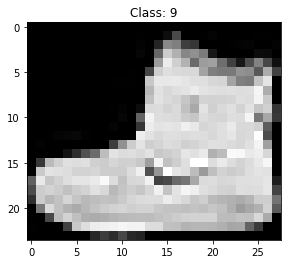

<Figure size 432x288 with 0 Axes>

In [5]:
plt.imshow(X_train_Total.loc[0].to_numpy().reshape(24, 28), cmap = 'gray')
plt.title('Class: {}'.format(y_train_Total[0]))
plt.figure()

### Chacking for NaN values

To make sure that our classifiers will work correctly, we need to check if any of the values of the dataframe are NaN. As shown below, there are none, so we can continue on.

In [6]:
na = X_train_Total.isna().sum().sum() + X_test_Final.isna().sum().sum() + pd.DataFrame(y_train_Total).isna().sum().sum() + pd.DataFrame(y_test_Final).isna().sum().sum()
print("There are", na, "NaN values")

There are 0 NaN values


### Data Splitting

So as not to introduce bias to our program, our calssifiers and all other actions performed on the data, we shall now split the data into a training and testing set. As we do not want to introduce bias when constructing and tuning our classifiers, we wish to not touch the testing set right up to the end, after the best classifier was chosen, we shall split the training set itself into a training and testing set (can also be called validation set), on which we shall run and tune our classifiers. We choose the size of the validation set of 10% of the data from which it splits (the training set), as the 10% (6000 records) are, in my opinion, enough to determine the quality of the classifiers.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_train_Total, y_train_Total,
                                                                test_size = 0.1, random_state = 0)

### Removing Duplicates

We need to check that the training set does not contain duplicates (all feature values are the same), as they are not helpful for the classifiers. When found, the duplicates can be safely removed. This is run on the training set, and was not done before the split into training and testing sets because in theory, the same image as the one the calssifiers were trained on can be given to the classifier to test and return an answer on the image's class of clothing. Hence, the duplicates should be removed only from the training set, and not from the validation set or from the test set.<br>
This is done by first merging the X_train and the y_train so that when duplicates are found, they are removed together with the label, otherwise the record will be removed from X_train and not removed from y_train, thus leaving different dimentions than the ones needed for the classifiers.

In [8]:
def removeDuplicates(X_train, y_train):
    warnings.filterwarnings('ignore')
    x = X_train
    x['y'] = y_train

    x = x.drop_duplicates()

    X_train = x.drop(['y'], axis = 1)
    y_train = x['y']
    return X_train, y_train

X_train, y_train = removeDuplicates(X_train, y_train)
X_train.shape

(54000, 672)

### Scaling

Next, we need to normalize our data, meaning transforming every value of 1-255 (the possible grayscale values of each pixel) to values in the range [0, 1]. This is done because most (if not all) classifiers expect and work best on such values from 0 to 1. This is done using the MinMaxScaler() method. The scaling is fitted to the train data, then both the train and the test data are transformed according to what was fitted.<br>
Note: standartization was not used instead, because the data we are evaluating does not have any outliers, so we need not concern ourselves with them (all values range from 0 to 255).

In [9]:
def scale(X_train, X_test, X_test_Final):
    min_max_scaler = MinMaxScaler()
    X_train = pd.DataFrame(min_max_scaler.fit_transform(X_train.values)) #fitting and transforming on train data
    X_test = pd.DataFrame(min_max_scaler.transform(X_test.values)) #only transforming the test and validation sets
    X_test_Final = pd.DataFrame(min_max_scaler.transform(X_test_Final.values))
    return X_train, X_test, X_test_Final

X_train, X_test, X_test_Final = scale(X_train, X_test, X_test_Final)

X_train

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.0,0.0,0.0,0.000000,0.000000,0.003922,0.000000,0.011765,0.000000,0.000000,...,0.564706,0.611765,0.309804,0.533333,0.674510,0.368627,0.000000,0.000000,0.000000,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.592157,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.203922,0.898039,...,0.819608,0.466667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.007843,0.000000,0.043137,0.376471,0.788235,...,0.235294,0.019608,0.513725,0.650980,0.529412,0.376471,0.000000,0.000000,0.000000,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003922,0.000000,0.317647,0.658824,0.470588,0.482353,0.490196,0.482353,0.286275,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53995,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.286275,0.627451,0.721569,0.709804,...,0.682353,0.647059,0.678431,0.145098,0.000000,0.019608,0.000000,0.000000,0.000000,0.0
53996,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.015686,0.000000,...,0.858824,0.000000,0.039216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
53997,0.0,0.0,0.0,0.007843,0.000000,0.000000,0.737255,0.921569,0.827451,0.854902,...,0.850980,0.850980,0.874510,0.678431,0.345098,0.752941,0.541176,0.686275,0.317647,0.0
53998,0.0,0.0,0.0,0.000000,0.003922,0.000000,0.000000,0.223529,0.435294,0.360784,...,0.000000,0.000000,0.160784,0.474510,0.364706,0.258824,0.000000,0.000000,0.000000,0.0


### PCA

<b>Dimensionality Reduction:</b><br>
When working with data which has many dimensions, it is often wise to attempt to quicken the classifiers by reducing the number of dimensions used to fit the data. Clearly, the removal of some dimensions will cause the classifier to perform worse than if it were run on the full data, but it can be very beneficial due to it expediting the runtime of the program dramatically. The problem occurs when we try to choose which dimensions to remove from examination, as it could be the feature having a crucial impact on the results of our classifier. This is what the PCA attempts to help us choose.

<b>What is PCA?</b><br>
The PCA algorithm attempts to help us use dimensionality reduction to reduce runtime while slightly reducing the accuracy of the classifiers. Using some linear algebra, the algorithm chooses the number of dimensions (as can be specified using the n_components hyperparameter) which are the most useful for the classifiers. When n_components is set to a value between 0 and 1, the algorithm covers the percentage of variance specified (very useful, as it is making the PCA flexible for different data, or for approximating the accuracy drop of the final classifier).

The PCA should be trained and fitted on the training set, and then the trained PCA should be used to transform the training, the validation, and the testing sets. Training the PCA on the test and validation sets is not right, as it means that we are using both the training and testing to fit the data to a certain shape, while analyzing it as a whole, which is incorrect, as the test and validation sets should only be used to test the results.
Despite that, the test and validation sets still has to be changed according to what the PCA has fitted on the training set, due to all classifiers requiring the data to be of the same shape in order to work on them.

We can see that the amount of records in the training set has not changes, whereas the number of features has dropped drastically from 10000 to 335! That is only a small fraction of of the amount of features before the use of PCA, which still result in a relatively good accuracy score.

In [10]:
def PCAFunc(X_train, X_test, X_test_Final):
    pca = PCA(n_components=0.9)
    X_train_Reduced = pd.DataFrame(pca.fit_transform(X_train))
    X_test_Reduced = pd.DataFrame(pca.transform(X_test))
    X_test_Final_Reduced = pd.DataFrame(pca.transform(X_test_Final))
    return X_train_Reduced, X_test_Reduced, X_test_Final_Reduced

X_train_Reduced, X_test_Reduced, X_test_Final_Reduced = PCAFunc(X_train, X_test, X_test_Final)

X_train_Reduced.shape

(54000, 75)

## Classifiers

For Each classifier, besides the explanation as to how the classifier performs its job (briefly), a confusion matrix and a classification report are added in order to help us judge the classifier's performance. What exactly the matrix and the report show us is explained in detail in the "Airline Satisfaction" notebook, but in this notebook it has much more significance (although its purpose is the same), as here we tackle a multiclass classification problem with 10 different classes (items of clothing).

### Dummy Classifier

Before choosing and applying the models to the data, we need a baseline classifier, to compare all others to it: if the classifiers thereafter are worse than the base classifier, we are doing something wrong. If the classifier is better than the base classifier, on the other hand, it means that the model works, and can be better at predicting than a "dummy" classifier. The base classifier we will use is <b>Dummy Classifier</b>, which will, regardless of the input, put in the most frequent value in y_train. It puts in the most frequent value due to the strategy we have put into the model, although we could choose differently, but this strategy seems to return the best results.

Accuracy (KNN):  0.09433333333333334
Time taken to achive result: 0.003989219665527344 seconds
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       583
           1       0.00      0.00      0.00       588
           2       0.00      0.00      0.00       633
           3       0.00      0.00      0.00       619
           4       0.00      0.00      0.00       597
           5       0.00      0.00      0.00       632
           6       0.00      0.00      0.00       578
           7       0.09      1.00      0.17       566
           8       0.00      0.00      0.00       580
           9       0.00      0.00      0.00       624

    accuracy                           0.09      6000
   macro avg       0.01      0.10      0.02      6000
weighted avg       0.01      0.09      0.02      6000



<AxesSubplot:>

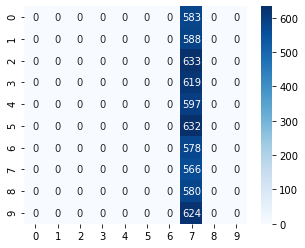

In [11]:
#Dummy
start_timeDummy = time.time()
dummyModel = DummyClassifier(strategy="most_frequent")
dummyModel.fit(X_train_Reduced, y_train)
predictionsDummy = dummyModel.predict(X_test_Reduced)

accuracyDummy = metrics.accuracy_score(y_test, predictionsDummy)
print("Accuracy (KNN): ", accuracyDummy)
timeDummy = time.time() - start_timeDummy
print("Time taken to achive result: %s seconds" % (timeDummy))

plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsDummy, zero_division = 0))
sns.heatmap(confusion_matrix(y_test, predictionsDummy), cmap = "Blues", annot=True, fmt = '.0f')

### KNN Classifier

We will first use the <b>KNN classifier</b>. The KNN classifier (K nearest Neighbors) is one that chooses the value closest to the values from the train set. if K = 1, then it chooses depending on the single closest neighbor to the wanted data; if N > 1, then it chooses the label depending on the N closest neighbors (in terms of data). The "weights" parameter specifies whether the model is to give a higher penalty for the neighbors further away or to count their value as equally valuable to determine the label.

Accuracy (KNN):  0.8508333333333333
Time taken to achive result: 3.9274098873138428 seconds
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       583
           1       0.99      0.96      0.97       588
           2       0.76      0.74      0.75       633
           3       0.89      0.85      0.87       619
           4       0.72      0.73      0.73       597
           5       0.99      0.89      0.93       632
           6       0.60      0.63      0.62       578
           7       0.91      0.96      0.93       566
           8       0.98      0.96      0.97       580
           9       0.91      0.96      0.93       624

    accuracy                           0.85      6000
   macro avg       0.85      0.85      0.85      6000
weighted avg       0.85      0.85      0.85      6000



<AxesSubplot:>

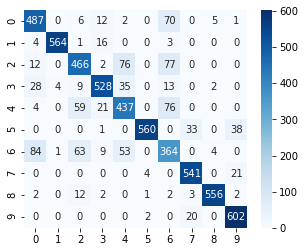

In [12]:
#KNN
start_timeKNN = time.time()
modelKNN = KNeighborsClassifier(n_neighbors = 5, weights='distance')
modelKNN.fit(X_train_Reduced, y_train)
predictionsKNN = modelKNN.predict(X_test_Reduced)
accuracyKNN = metrics.accuracy_score(y_test, predictionsKNN)
print("Accuracy (KNN): ", accuracyKNN)
timeKNN = time.time() - start_timeKNN
print("Time taken to achive result: %s seconds" % (timeKNN))

plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsKNN))
sns.heatmap(confusion_matrix(y_test, predictionsKNN), cmap = "Blues", annot=True, fmt = '.0f')

### Logistic Regression Classifier

For our second classifier we will choose <b>Logistic Regression</b>. This classifier is chosen because it makes no assumptions regarding the distribution of labels, it works according to probabilities which it calculates for each record in the dataframe, and it is a fairly simple classifier that yet works well with many datasets. The classifier tries to fit an S shape to the data (as opposed to linear regression that fits a straight line), where the edges of the S are values where the probability is very high for a label to occur, and closer to the middle of the S, it is lower. We can also set a threshold "on the S", from which the classifier will predict a certain value. This is usually done when a certain value is preferred over the other. As we try to be objective with the reviews, we will not do it.

Accuracy (KNN):  0.8508333333333333
Time taken to achive result: 2.9911088943481445 seconds
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       583
           1       0.98      0.96      0.97       588
           2       0.71      0.68      0.70       633
           3       0.82      0.86      0.84       619
           4       0.68      0.72      0.70       597
           5       0.93      0.92      0.92       632
           6       0.54      0.51      0.53       578
           7       0.90      0.93      0.91       566
           8       0.95      0.92      0.94       580
           9       0.95      0.95      0.95       624

    accuracy                           0.83      6000
   macro avg       0.83      0.83      0.83      6000
weighted avg       0.83      0.83      0.83      6000



<AxesSubplot:>

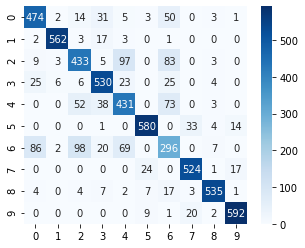

In [13]:
#Logistic Regression
start_timeLogReg = time.time()
modelLogReg = LogisticRegression()
modelLogReg.fit(X_train_Reduced, y_train)
predictionsLogReg = modelLogReg.predict(X_test_Reduced)
accuracyLogReg = modelLogReg.score(X_test_Reduced, y_test)
print("Accuracy (KNN): ", accuracyKNN)
timeLogReg = time.time() - start_timeLogReg
print("Time taken to achive result: %s seconds" % (timeLogReg))

plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsLogReg))
sns.heatmap(confusion_matrix(y_test, predictionsLogReg), cmap = "Blues", annot=True, fmt = '.0f')

### Random Forests Classifier

We can now move on to more advanced models that use Ensemble Learning (the concept is explained in detail in the "Airline Satisfaction" notebook). The first one of these shall be the <b>Random Forests</b> Classifier. This classifier uses ensemble learning by constructing a multitude of decision trees (specified with the n_estimators hyperparameter, defaults at 100), without a maximum depth of each tree (such depth can be added using the max_depth hyperparameter, but after several tests, the result was that not limiting the trees is best in the case of this data). After several tests, the number of estimators was set to 300, as the best correlation of accuracy to time and resource consumption.<br>
For the test set, each trees prediction is calculated, the results then aggregated, and the final answer is given. The aggregation is performed by each trees result counted and the "majority vote" is the final answer of the classifier.

Accuracy (Random Forests):  0.8643333333333333
Time taken to achive result: 17.752670288085938 seconds
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       583
           1       0.99      0.95      0.97       588
           2       0.78      0.77      0.77       633
           3       0.87      0.90      0.88       619
           4       0.75      0.78      0.77       597
           5       0.94      0.94      0.94       632
           6       0.68      0.59      0.63       578
           7       0.94      0.93      0.94       566
           8       0.95      0.96      0.95       580
           9       0.93      0.96      0.94       624

    accuracy                           0.86      6000
   macro avg       0.86      0.86      0.86      6000
weighted avg       0.86      0.86      0.86      6000



<AxesSubplot:>

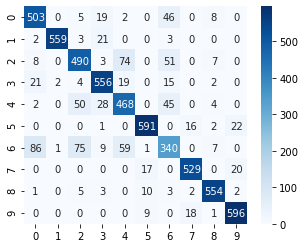

In [14]:
#Random Forests
start_timeRandForests = time.time()
modelRandForests = RandomForestClassifier(n_estimators = 300, n_jobs = -1, random_state = 0)
modelRandForests.fit(X_train_Reduced, y_train)
predictionsRandForests = modelRandForests.predict(X_test_Reduced)
accuracyRandForests = metrics.accuracy_score(y_test, predictionsRandForests)
print("Accuracy (Random Forests): ", accuracyRandForests)
timeRandForests = time.time() - start_timeRandForests
print("Time taken to achive result: %s seconds" % (timeRandForests))

plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsRandForests))
sns.heatmap(confusion_matrix(y_test, predictionsRandForests), cmap = "Blues", annot=True, fmt = '.0f')

### AdaBoost Classifier

Next, we will check the performance of the <b>AdaBoost Classifier</b> (AdaBoost stands for Adaptive Boost). This classifier also uses ensemble learning to achieve its purpose. After receiving the results from some base classifier, in our case the Decision Tree Classifier, the model then performs the base classifier over and over (n_estimator times), while each time giving more weight to the misclassified training instances. Then, again using ensemble learning techniques the model returns its final answer according to the many sub-models it created.<br>
The learning rate hyperparameter set to 0.2 (defaults at 1) after several tests to determine the best value. The hyperparameter specifies the rate of adaptability of the classifier to the data after each iteration of the estimator.

Accuracy (AdaBoost):  0.6036666666666667
Time taken to achive result: 164.287691116333 seconds
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       583
           1       0.97      0.49      0.65       588
           2       0.44      0.79      0.56       633
           3       0.52      0.78      0.63       619
           4       0.52      0.40      0.46       597
           5       0.51      0.91      0.65       632
           6       0.28      0.10      0.15       578
           7       0.54      0.14      0.22       566
           8       0.83      0.93      0.88       580
           9       0.91      0.75      0.82       624

    accuracy                           0.60      6000
   macro avg       0.63      0.60      0.57      6000
weighted avg       0.62      0.60      0.58      6000



<AxesSubplot:>

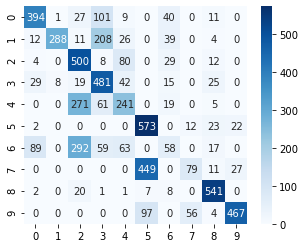

In [15]:
#AdaBoost
start_timeAdaBoost = time.time()
modelDecTree = DecisionTreeClassifier(random_state=0, max_depth=2)
modelAdaBoost = AdaBoostClassifier(modelDecTree, n_estimators = 200, random_state = 0, learning_rate = 0.2)
modelAdaBoost.fit(X_train_Reduced, y_train)
predictionsAdaBoost = modelAdaBoost.predict(X_test_Reduced)
accuracyAdaBoost = metrics.accuracy_score(y_test, predictionsAdaBoost)
print("Accuracy (AdaBoost): ", accuracyAdaBoost)
timeAdaBoost = time.time() - start_timeAdaBoost
print("Time taken to achive result: %s seconds" % (timeAdaBoost))

plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsAdaBoost))
sns.heatmap(confusion_matrix(y_test, predictionsAdaBoost), cmap = "Blues", annot=True, fmt = '.0f')

### XGBoost Classifier

Last of the single models (but certainly not least), we shall run the <b>XGBoost Classifier</b> on our data (XGBoost standing for Extreme Gradient Boosting, which uses Ensemble Learning and boosting in a similar yet different way to AdaBoost above. Where AdaBoost tweaks the individual instance weights, giving some more or less weight, XGBoost fits a new predictor to the residual errors made by the previous predictor. It should be noted that the residual errors get smaller with each iteration of XGBoost, making the model very effective (in many cases the most effective out of all).

After several tests, the number of estimators was set to 700, with the learning rate of 0.2 as the best correlation of efficiency of the classifier. That said, the accuracy could be boosted by lowering the learning rate and/or increasing the number of estimators. During trials, on average, an increase in accuracy of 0.1% (0.001) "costs" 100-200 seconds, which in my opinion is not a good bargain.

In [16]:
start_timeXGBoost = time.time()
modelXGBoost = XGBClassifier(learning_rate = 0.2, n_estimators = 700, verbosity = 0, use_label_encoder = False,
                             n_jobs = -1, objective = 'multi:softmax')
modelXGBoost.fit(X_train_Reduced, y_train)
predictionsXGBoost = modelXGBoost.predict(X_test_Reduced)
accuracyXGBoost = metrics.accuracy_score(y_test, predictionsXGBoost)
print("Accuracy (XGBoost): ", accuracyXGBoost)
timeXGBoost = time.time() - start_timeXGBoost
print("Time taken to achive result: %s seconds" % (timeXGBoost))

plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsXGBoost))
sns.heatmap(confusion_matrix(y_test, predictionsXGBoost), cmap = "Blues", annot=True, fmt = '.0f')

KeyboardInterrupt: 

### Voting Classifier

Now that all models are trained, and they are not bad, we can try to combine them and get "the best out of all worlds". This we shall first try by using the <b>Voting Classifier</b>. This classifier takes the results of each model (given in the "estimators" hyperparameter), and compares the results given by each model for every record of the dataframe, returning the value which most classifiers agree on. The voting method was changed to "soft", meaning that from each classifier, the probability of each result will be considered ("how sure the classifier is that its final decision is correct"), rather than the raw "yes or no" in the case of "hard" voting method. The weights of each model in the evaluation are also given, for we know that the last 3 classifiers had better results than the first two.

In [ ]:
#Voting
start_timeVoting = time.time()
modelVoting = VotingClassifier(
    estimators=
        [('KNN', modelKNN),
         ('LogReg', modelLogReg),
         ('RandForests', modelRandForests),
         ('AdaBoost', modelAdaBoost),
         ('XGBoost', modelXGBoost)],
    voting='soft', n_jobs=-1, weights=[1, 1, 3, 3, 3])
modelVoting.fit(X_train_Reduced, y_train)
predictionsVoting = modelVoting.predict(X_test_Reduced)
accuracyVoting = metrics.accuracy_score(y_test, predictionsVoting)
print("Accuracy: ", accuracyVoting)
timeVoting = time.time() - start_timeVoting
print("Time taken to achive result: %s seconds\n\n" % (timeVoting))

plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsVoting))
sns.heatmap(confusion_matrix(y_test, predictionsVoting), cmap = "Blues", annot=True, fmt = '.0f')

### Bagging and Pasting Classifiers

Another option we will now observe is to use the <b>Bagging/Pasting Classifiers</b>. These classifiers combine not many different models, but a single model where the data is divided into multiple parts (the number is defined in the n_estimators hyperparameter), and a single model is run on all these subsections, resulting in a quite accurate model. When the samples taken from the complete dataset can be chosen twice or more for a single predictor, the model is called Bagging, if not then it is Pasting. In practice, Pasting is used more when the dataset is large, while for smaller datasets, the Bagging Classifier may be a good choice. We will try to use both classifiers to see how it performs on our data. The difference between the two classifiers in code is only the "bootstrap" hyperparameter. We will Use the XGBoost calssifier as the estimator, as it performed best out of the classifiers we have evaluated up to this point, but we shall reduce the number of estimators in each XGBoost run to reduce runtime.

#### Bagging Classifier

In [ ]:
#Bagging
modelXGBoost = XGBClassifier(learning_rate = 0.2, n_estimators = 400, verbosity = 0, use_label_encoder = False,
                             n_jobs = -1, objective = 'multi:softmax')
start_timeBagging = time.time()
warnings.filterwarnings('ignore')
modelBagging = BaggingClassifier(modelXGBoost, n_estimators = 100, bootstrap = True)
modelBagging.fit(X_train_Reduced, y_train)
predictionsBagging = modelBagging.predict(X_test_Reduced)
accuracyBagging = metrics.accuracy_score(y_test, predictionsBagging)
print("Accuracy: ", accuracyBagging)
timeBagging = time.time() - start_timeBagging
print("Time taken to achive result: %s seconds\n\n" % (timeBagging))

plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsBagging))
sns.heatmap(confusion_matrix(y_test, predictionsBagging), cmap = "Blues", annot=True, fmt = '.0f')

#### Pasting Classifier

In [ ]:
#Pasting
start_timePasting = time.time()
warnings.filterwarnings('ignore')
modelPasting = BaggingClassifier(modelXGBoost, n_estimators = 100, bootstrap = False)
modelPasting.fit(X_train_Reduced, y_train)
predictionsPasting = modelPasting.predict(X_test_Reduced)
accuracyPasting = metrics.accuracy_score(y_test, predictionsPasting)
print("Accuracy: ", accuracyPasting)
timePasting = time.time() - start_timePasting
print("Time taken to achive result: %s seconds\n\n" % (timePasting))

plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsPasting))
sns.heatmap(confusion_matrix(y_test, predictionsPasting), cmap = "Blues", annot=True, fmt = '.0f')

### Stacking Classifier

The last ensemble method we will evaluate is the <b>Stacking Classifier</b>. This uses the simple yet elegant idea to take the results given by each predictor for each method, and unlike the voting classifier, build a new model to evaluate them and return an answer, which shall be the final result for the instance for this classifier.

In [ ]:
#Stacking
start_timeStacking = time.time()
warnings.filterwarnings('ignore')
modelStacking = StackingClassifier(estimators= [('KNN', modelKNN),
                                      ('LogReg', modelLogReg),
                                      ('RandForests', modelRandForests),
                                      ('AdaBoost', modelAdaBoost),
                                      ('XGBoost', modelXGBoost)], 
                         final_estimator=LogisticRegression())
modelStacking.fit(X_train_Reduced, y_train)
predictionsStacking = modelStacking.predict(X_test_Reduced)
accuracyStacking = metrics.accuracy_score(y_test, predictionsStacking)
print("Accuracy: ", accuracyStacking)
timeStacking = time.time() - start_timeStacking
print("Time taken to achive result: %s seconds\n\n" % (timeStacking))

plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsStacking))
sns.heatmap(confusion_matrix(y_test, predictionsStacking), cmap = "Blues", annot=True, fmt = '.0f')

## Classifier Evaluation

We will plot a bar graph to help us see the accuracies better and limiting the y axis so that the differences are more pronounced. Here, the accuracies can be judged much better than any other method, with the Voting Classifier being the best, with XGBoost and Bagging Classifiers close behind. The Dummy classifier has, as expected , performed worse than all our other classifiers, meaning all models have some functionality and are not a total waste.

In [ ]:
def accuraciesGraph(bounds):
    accuracies = [accuracyDummy, accuracyKNN, accuracyLogReg, accuracyRandForests, accuracyAdaBoost, accuracyXGBoost,
                  accuracyVoting, accuracyBagging, accuracyPasting, accuracyStacking]
    fig = plt.figure(figsize=(13,6))
    accuraciesSize = np.arange(len(accuracies))
    axes = fig.add_axes([0,0,1,1])
    labels = ['Dummy', 'KNN', 'Logistic Regression', 'Random Forest', 'AdaBoost', 'XGBoost', 'Voting', 'Bagging', 'Pasting'
              'Stacking']
    axes.bar(labels, accuracies)
    axes.set_ylabel("Accuracy Score")
    axes.set_title("Accuracy Scores of the Different Classifiers")
    plt.rcParams['xtick.labelsize'] = 10
    axes.set_ylim(bounds)
    
accuraciesGraph([0.09, 0.9])

Next, The bar graph for the runtimes is shown. We can identify the Bagging and Pasting Classifiers as the ones with the longest runtime. These classifiers are so long compared to the all the others, that it is very hard to judge the other classifiers. For this purpose, we shall plot another Time Graph, in which we will not show these models, and see what we can determine.

In [ ]:
def timeGraph(time, labels):
    fig = plt.figure(figsize=(13,6))

    timeSize = np.arange(len(time))
    axes = fig.add_axes([0,0,1,1])
    labels = ['Dummy', 'KNN', 'Logistic Regression', 'Random Forest', 'AdaBoost', 'XGBoost', 'Voting', 'Bagging',
              'Pasting', 'Stacking']
    axes.bar(labels, time)
    axes.set_ylabel("Runtime (Seconds)")
    axes.set_title("Runtimes of the Different Classifiers")
    plt.rcParams['xtick.labelsize'] = 10

time = [timeDummy, timeKNN, timeLogReg, timeRandForests, timeAdaBoost, timeXGBoost, timeVoting, timeBagging,
        timePasting, timeStacking]
labels = ['Dummy', 'KNN', 'Logistic Regression', 'Random Forest', 'AdaBoost', 'XGBoost', 'Voting', 'Bagging',
          'Pasting', 'Stacking']
timeGraph(time, labels)

As we can see, .....................????????????????????????????

In [ ]:
time = [timeDummy, timeKNN, timeLogReg, timeRandForests, timeAdaBoost, timeXGBoost, timeVoting, timeStacking]
labels = ['Dummy', 'KNN', 'Logistic Regression', 'Random Forest', 'AdaBoost', 'XGBoost', 'Voting', 'Stacking']
timeGraph(time, labels)

In [ ]:
results = pd.DataFrame(np.array([['Dummy (B&W)', accuracyDummy, timeDummy],
                            ['KNN (B&W)', accuracyKNN, timeKNN],
                            ['Logistic Regression (B&W)', accuracyLogReg, timeLogReg],
                            ['Random Forests (B&W)', accuracyRandForests, timeRandForests],
                            ['AdaBoost (B&W)', accuracyAdaBoost, timeAdaBoost],
                            ['XGBoost (B&W)', accuracyXGBoost, timeXGBoost],
                            ['Voting (B&W)', accuracyVoting, timeVoting],
                            ['Bagging (B&W)', accuracyBagging, timeBagging],
                            ['Pasting (B&W)', accuracyPasting, timePasting],
                            ['Stacking (B&W)', accuracyStacking, timeStacking]]),
                  columns=['Model', 'Accuracy', 'Runtime (Seconds)'])

resultsView = results.sort_values(by = 'Accuracy', axis = 0, ascending = False)
resultsView = resultsView.style.set_properties(**{'text-align': 'left'})
resultsView